# Downstream Analysis - R

Now we wrangle our data and plot results! Below, we do this using R tidyverse, cowplot, limma and multcomp packages

In [ ]:
# all_slow hide_output
library(cowplot)
library(limma)
library(multcomp)
library(tidyverse)
library(broom)

# number of sig figs in tables
options(digits = 3)

Loading required package: mvtnorm

Loading required package: survival

Loading required package: TH.data

Loading required package: MASS


Attaching package: ‘TH.data’


The following object is masked from ‘package:MASS’:

    geyser


── Attaching packages ───────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ──────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()



First, we read in results previously generated by py_clone_detector:

In [ ]:
# hide_output
count_df <- read_csv("data/example_results.csv")


── Column specification ──────────────────────────────────────────
cols(
  .default = col_double(),
  int_img = col_character(),
  seg_ch = col_character(),
  int_img_ch = col_character(),
  seg_img = col_character(),
  GFP_clonepos = col_logical(),
  EC_pos = col_logical(),
  EE_pos = col_logical(),
  ECEE_pos = col_logical(),
  ISCorEB_pos = col_logical(),
  preEC_pos = col_logical()
)
ℹ Use `spec()` for the full column specifications.




In [ ]:
count_df %>% head()

int_img,label,GFP_clone,GFPneg_nc,GFPpos_nc,tot_nc,ECneg_nc,ECpos_nc,EEneg_nc,EEpos_nc,⋯,centroid-1,eccentricity,area_um2,GFP_clonepos,total_intensity,EC_pos,EE_pos,ECEE_pos,ISCorEB_pos,preEC_pos
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
a1g01p1,11,0,2,2,4,1,3,4,0,⋯,89.6,0.441,73.3,FALSE,2196457,TRUE,FALSE,FALSE,FALSE,FALSE
a1g01p1,11,0,2,2,4,1,3,4,0,⋯,89.6,0.441,73.3,FALSE,52757,TRUE,FALSE,FALSE,FALSE,FALSE
a1g01p1,11,0,2,2,4,1,3,4,0,⋯,89.6,0.441,73.3,FALSE,2262648,TRUE,FALSE,FALSE,FALSE,FALSE
a1g01p1,11,0,2,2,4,1,3,4,0,⋯,89.6,0.441,73.3,FALSE,67331,TRUE,FALSE,FALSE,FALSE,FALSE
a1g01p1,12,0,4,0,4,1,3,4,0,⋯,486.8,0.465,98.7,FALSE,4113516,TRUE,FALSE,FALSE,FALSE,FALSE
a1g01p1,12,0,4,0,4,1,3,4,0,⋯,486.8,0.465,98.7,FALSE,99772,TRUE,FALSE,FALSE,FALSE,FALSE


## Cell Proliferation - number of cells per clone

Out first aim is to determine whether there is a difference in the number of cells per clone. To do this, we first query an intensity image channel so that we do not count a cell (label) multiple times. Next, for simplicity, filter out columns not required for counting the number and type of cells per clone.

In [ ]:
# hide_output
count_df <- count_df %>%
  mutate(across(where(is_character), as_factor)) %>%
  filter(int_img_ch == "C1") %>%
  dplyr::select(matches("clone$|_pos$|int_img")) %>%
  group_by(int_img, GFP_clone) %>%
  summarise(
    EC = sum(EC_pos), 
    ECEE = sum(ECEE_pos),
    preEC = sum(preEC_pos),
    EE = sum(EE_pos),
    ISCorEB = sum(ISCorEB_pos)
  ) %>%
  mutate(clone_status = as.factor(if_else(GFP_clone == 0, "OC", "IC")), 
         genotype = as.factor(if_else(str_detect(int_img, "a1"), "ctrl", "mut")),
         total = EC + ECEE + preEC + EE + ISCorEB)

`summarise()` has grouped output by 'int_img'. You can override using the `.groups` argument.



In [ ]:
head(count_df)

int_img,GFP_clone,EC,ECEE,preEC,EE,ISCorEB,clone_status,genotype,total
<fct>,<dbl>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<int>
a1g01p1,0,70,4,1,2,98,OC,ctrl,175
a1g01p1,1,9,0,0,0,5,IC,ctrl,14
a1g01p1,2,0,0,0,0,1,IC,ctrl,1
a1g01p1,3,1,0,0,0,3,IC,ctrl,4
a1g01p1,4,12,1,0,0,21,IC,ctrl,34
a1g01p1,5,12,1,0,2,19,IC,ctrl,34


In [ ]:
count_df_tidy <- count_df %>%
  pivot_longer(cols = EC:ISCorEB, names_to = "cell_type", values_to = "cell_num") %>%
  mutate(cell_type = factor(cell_type, levels = c("ECEE", "EE", "EC", "preEC", "ISCorEB")))

In [ ]:
count_df_tidy_inside <- count_df_tidy %>% filter(clone_status == "IC")

In [ ]:
# create stacked bar plots
stacked_bar_mean <- count_df_tidy_inside %>%
  filter(clone_status == "IC") %>%
  ggplot(aes(fill = cell_type, y = cell_num, x = genotype)) +
  geom_bar(
    position = "stack",
    stat = "summary", fun = "mean"
  ) +
  theme_bw() +
  scale_fill_manual(values = c(
    "#000000",
    "#95a5a6", "#F57171", "#539DC2", "#008b68"
  ))

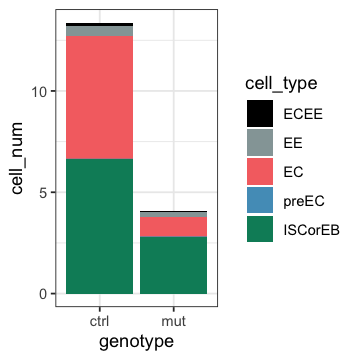

In [ ]:
# setup plot size, theme and text size
options(repr.plot.width = 3, repr.plot.height = 3)
theme_set(theme_cowplot(font_size = 14))

stacked_bar_mean

In [ ]:
glm(total ~ genotype, count_df, family = "poisson") %>% tidy()

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),3.837,0.0097,395.4,0.00e+00
genotypemut,-0.456,0.0149,-30.6,5.35e-206


In [ ]:
stacked_bar_prop <- count_df_tidy %>%
  ggplot(aes(fill = cell_type, y = cell_num, x = genotype)) +
  geom_bar(
    position = "fill",
    stat = "identity"
  ) +
  theme_bw() +
  facet_wrap(vars(clone_status)) +
  scale_fill_manual(values = c(
    "#000000",
    "#95a5a6", "#F57171", "#539DC2", "#008b68", "#000000"
  )) +
  theme(legend.position = "none")

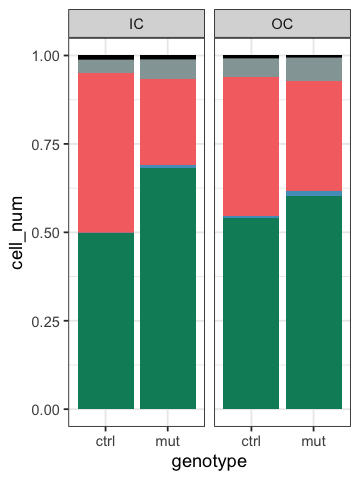

In [ ]:
# setup plot size, theme and text size
options(repr.plot.width = 3, repr.plot.height = 4)
theme_set(theme_cowplot(font_size = 14))

stacked_bar_prop

In [ ]:
prop_df_tidy <- count_df_tidy %>%
  mutate(pro_cell_num = cell_num / total, 
         g_cs_ct = as.factor(paste(genotype, clone_status, cell_type, sep = "_")))

In [ ]:
glm(pro_cell_num ~ genotype * clone_status * cell_type,
    data = prop_df_tidy,
    family = quasibinomial) %>% tidy()

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-5.1185,0.544,-9.4028,1.18e-20
genotypemut,-0.0260,0.741,-0.0351,9.72e-01
clone_statusOC,0.3450,1.227,0.2811,7.79e-01
cell_typeEE,1.6737,0.596,2.8098,5.00e-03
cell_typeEC,4.7333,0.551,8.5903,1.51e-17
cell_typepreEC,-1.7031,1.381,-1.2331,2.18e-01
cell_typeISCorEB,5.3482,0.551,9.7091,6.78e-22
genotypemut:clone_statusOC,-0.1930,1.818,-0.1061,9.15e-01
genotypemut:cell_typeEE,0.8325,0.795,1.0474,2.95e-01


We next setup out desired contrasts using 

In [ ]:
contr <- limma::makeContrasts(
  mut_IC_ECEE - ctrl_IC_ECEE,
  mut_IC_EE - ctrl_IC_EE,
  mut_IC_EC - ctrl_IC_EC,
  mut_IC_preEC - ctrl_IC_preEC,
  mut_IC_ISCorEB - ctrl_IC_ISCorEB,
  mut_OC_ECEE - mut_IC_ECEE,
  mut_OC_EE - mut_IC_EE,
  mut_OC_EC - mut_IC_EC,
  mut_OC_preEC - mut_IC_preEC,
  mut_OC_ISCorEB - mut_IC_ISCorEB,
  levels = levels(prop_df_tidy$g_cs_ct)
)

In [ ]:
model <- glm(pro_cell_num ~ g_cs_ct, prop_df_tidy, family = quasibinomial)

G <- glht(model, mcp(g_cs_ct = t(contr)))

tidy(G, test = adjusted("BH")) %>%
  mutate(
    sig_anot = case_when(
      adj.p.value < 0.0001 ~ '****',
      adj.p.value < 0.001 ~ '***',
      adj.p.value < 0.01 ~ '**',
      adj.p.value < 0.05 ~ '*',
      adj.p.value < 1 ~ 'ns'
    )
  )

term,contrast,null.value,estimate,std.error,statistic,adj.p.value,sig_anot
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
g_cs_ct,mut_IC_ECEE - ctrl_IC_ECEE,0,-0.0260,0.741,-0.0351,9.72e-01,ns
g_cs_ct,mut_IC_EE - ctrl_IC_EE,0,0.8064,0.286,2.8173,9.69e-03,**
g_cs_ct,mut_IC_EC - ctrl_IC_EC,0,-1.1502,0.131,-8.7474,0.00e+00,****
g_cs_ct,mut_IC_preEC - ctrl_IC_preEC,0,1.3296,1.403,0.9476,4.90e-01,ns
g_cs_ct,mut_IC_ISCorEB - ctrl_IC_ISCorEB,0,0.8487,0.122,6.9731,1.55e-11,****
g_cs_ct,mut_OC_ECEE - mut_IC_ECEE,0,0.1520,1.341,0.1133,9.72e-01,ns
g_cs_ct,mut_OC_EE - mut_IC_EE,0,-0.0324,0.441,-0.0734,9.72e-01,ns
g_cs_ct,mut_OC_EC - mut_IC_EC,0,0.7743,0.240,3.2226,4.23e-03,**
g_cs_ct,mut_OC_preEC - mut_IC_preEC,0,1.2188,1.059,1.1509,4.16e-01,ns
